# Case Study: Interpolating Precipitation Data with Spatialize
On this document, the tools **`esi_hparams_search`** and **`esi_nongriddata`** will be employed to estimate daily precipitation over the Maipo Basin in Chile.

The ESI implementation for non-gridded data enables interpolation on a 2.5D scenario (a curved surface), as opposed to the more common 2D (flat surface) and 3D (volume) scenarios.

## Setup

We'll start by loading the required libraries and inputs.

In [1]:
# === Libraries ===
import sys
sys.path.append('../')
from utils import PrecipitationCaseStudy, SuppressOutput

import numpy as np
import pandas as pd

# Spatialize:
from spatialize.gs.esi import esi_hparams_search, esi_nongriddata
import spatialize.gs.esi.lossfunction as lf

# Other interpolators:
from scipy.interpolate import griddata, RBFInterpolator
from sklearn.model_selection import GridSearchCV
from pykrige.rk import Krige

# Plots:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(context='notebook', style='whitegrid')
pd.options.display.float_format = '{:,.2f}'.format

In [2]:
# Load case study
case_study = PrecipitationCaseStudy()

# ESI inputs
points, values, xi = case_study.model_inputs()


Since we are working with a real, geolocated scenario, we'll create a plot format function and set some parameters to ease plotting.

## Visualizing the Input Data
Let us now visualise the data we have just loaded.

### Precipitation Data

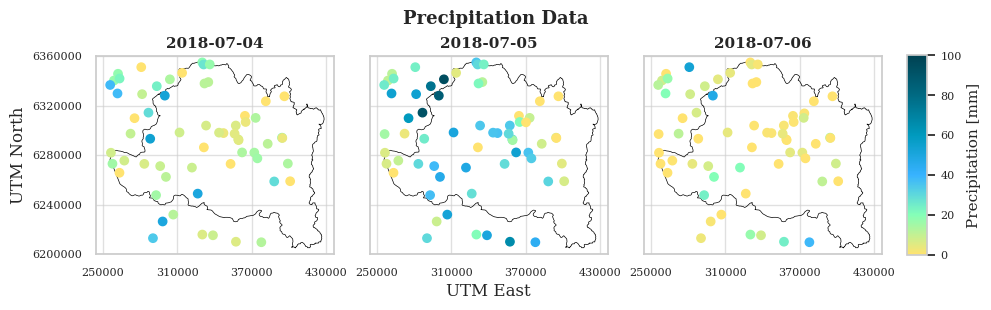

In [3]:
fig, axs = case_study.plot_input_data()
plt.show()


### Interpolation Locations

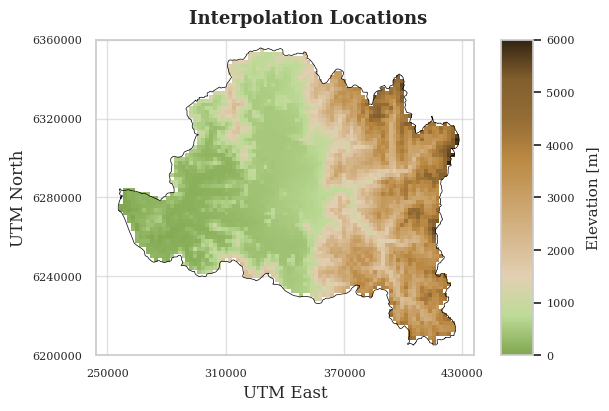

In [4]:
fig, ax = case_study.plot_interpolation_locations()
plt.show()


## Using ESI
In this section, we will implement the ESI algorithm to derive precipitation estimates across the whole surface of the Maipo Basin within three different dates.

**Modelling Setup**
- First, Inverse Distance Weighting (IDW) will be used as local interpolator; second, we'll use Kriging.
- The `esi_hparams_search` function will be used to identify optimal parameters for the `esi_nongriddata` function.
- Operational Error will be utilized for measuring uncertainty.

### ESI-IDW

In [5]:
# To store results
esi_idw_results = case_study.locs.copy()
esi_idw_results.columns = pd.MultiIndex.from_tuples([(x, '') for x in esi_idw_results.columns])

# To store parameters
parameters_idw = []

for date in case_study.dates:
    # Loss function: Operational error for the observed dynamic range
    op_error = lf.OperationalErrorLoss(np.abs(np.nanmin(values[date]) - np.nanmax(values[date])))

    # Searching for optimal parameters
    search_params = {'alpha': [0.7, 0.75, 0.8, 0.85, 0.9],
                     'exponent': np.round(np.arange(0.5, 3.1, 0.1), 1)}
    
    search_result = esi_hparams_search(points[date],
                                       values[date],
                                       xi,
                                       griddata=False,
                                       k=-1,
                                       n_partitions=[100],
                                       local_interpolator="idw",
                                       seed=1500,
                                       **search_params)
    
    best_params = search_result.best_result()

    # Using ESI
    result = esi_nongriddata(points=points[date],
                             values=values[date],
                             xi=xi,
                             n_partitions=300,
                             best_params_found=best_params)

    # Store results
    #esi_idw_results[(date, 'value')] = result._estimation
    esi_idw_results[(date, 'value')] = result.estimation()
    esi_idw_results[(date, 'precision')] = result.precision(op_error)
    
    # Store parameters (Optional):
    parameters_idw.append({'alpha': best_params['alpha'],
                           'exponent': best_params['exponent']
                           })

parameters_idw = pd.DataFrame(parameters_idw, index=case_study.dates)

finished 100% of 130 iterations ... 

done (elapsed time: 11s)
finished 100% of 300 iterations ... 

done (elapsed time:  0s)
finished 100% of 130 iterations ... 

done (elapsed time: 10s)
finished 100% of 300 iterations ... 

done (elapsed time:  0s)
finished 100% of 130 iterations ... 

done (elapsed time: 12s)
finished 100% of 300 iterations ... 

done (elapsed time:  0s)


In [6]:
# View optimal parameters
parameters_idw

,alpha,exponent
2018-07-04,0.70,3.00
2018-07-05,0.70,3.00
2018-07-06,0.70,3.00


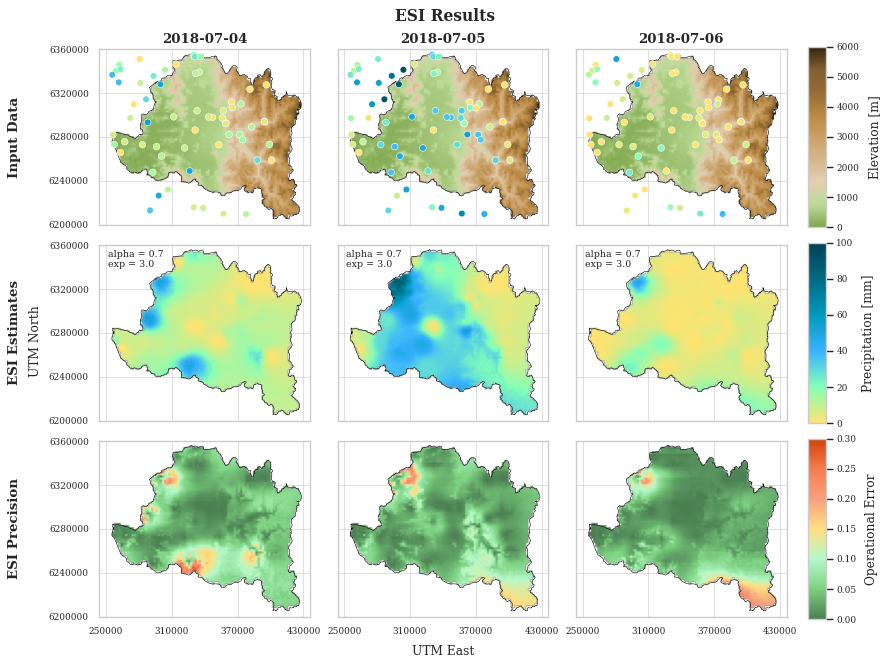

In [7]:
# Visualizing the results
case_study.plot_esi_results(esi_idw_results, parameters_idw, dpi=80)
plt.show()

The produced maps are consistent with the region's precipitation patterns-influenced by the Andes and the Costal Range - and accurately reproduce the values at the sampled locations. The estimates show reasonable values and spatial structure, effectively handling extreme values and abrupt transitions for all three dates.

The operational error values are reasonable, showing higher uncertainty at areas with less data.

### ESI-Kriging

In [8]:
# To store results
esi_kriging_results = case_study.locs.copy()
esi_kriging_results.columns = pd.MultiIndex.from_tuples([(x, '') for x in esi_kriging_results.columns])

# To store parameters
parameters_kriging = []

for date in case_study.dates:
    # Loss function: Operational error for the observed dynamic range
    op_error = lf.OperationalErrorLoss(np.abs(np.nanmin(values[date]) - np.nanmax(values[date])))

    # Searching for optimal parameters
    search_params = {'alpha': [0.7, 0.75, 0.8, 0.85, 0.9],
                     'model': ['spherical', 'exponential', 'cubic', 'gaussian'],
                     'nugget': [0.0, 0.5],
                     'range': [10.0, 100.0, 500.0],
                     'sill': [1.0]
                     }
    
    search_result = esi_hparams_search(points[date],
                                       values[date],
                                       xi,
                                       griddata=False,
                                       k=-1,
                                       n_partitions=[100],
                                       local_interpolator='kriging',
                                       seed=1500,
                                       **search_params)
    
    best_params = search_result.best_result()
    
    # Using ESI
    result = esi_nongriddata(points=points[date],
                             values=values[date],
                             xi=xi,
                             n_partitions=300,
                             best_params_found=best_params)

    # Store results
    esi_kriging_results[(date, 'value')] = result.estimation()
    esi_kriging_results[(date, 'precision')] = result.precision(op_error)
    
    # Store parameters (Optional):
    parameters_kriging.append({'alpha': best_params['alpha'],
                           'model': best_params['model'],
                           'nugget': best_params['nugget'],
                           'range': best_params['range']
                           })

parameters_kriging = pd.DataFrame(parameters_kriging, index=case_study.dates)

finished 100% of 120 iterations ... 

done (elapsed time: 18s)
finished 100% of 300 iterations ... 

done (elapsed time:  0s)
finished 100% of 120 iterations ... 

done (elapsed time: 19s)
finished 100% of 300 iterations ... 

done (elapsed time:  0s)
finished 100% of 120 iterations ... 

done (elapsed time: 20s)
finished 100% of 300 iterations ... 

done (elapsed time:  0s)


In [9]:
# View optimal parameters
parameters_kriging

,alpha,model,nugget,range
2018-07-04,0.90,spherical,0.00,10.00
2018-07-05,0.90,exponential,0.00,500.00
2018-07-06,0.90,spherical,0.00,500.00


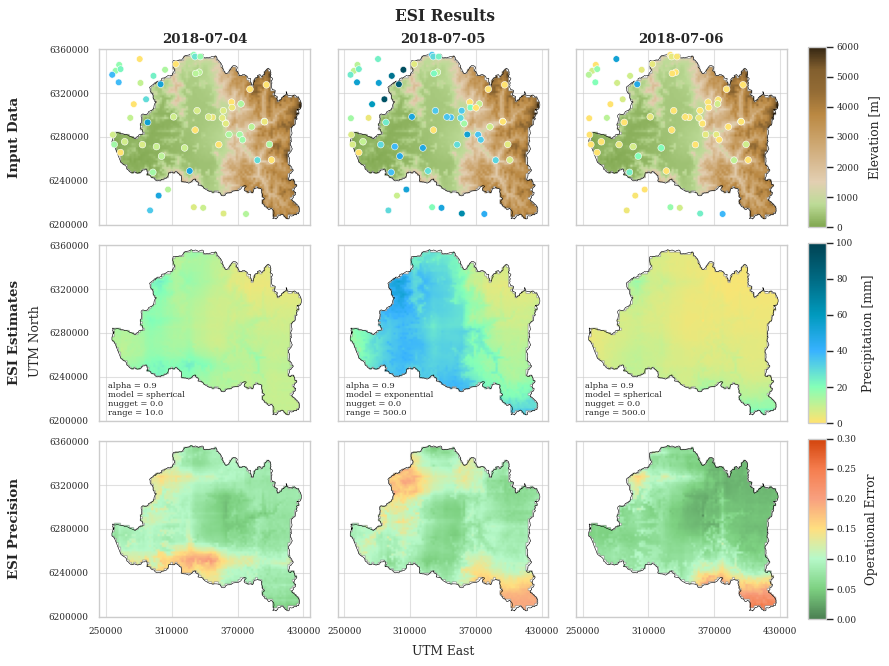

In [10]:
# Visualizing the results
parameters_kriging = pd.DataFrame(parameters_kriging, index=case_study.dates)

case_study.plot_esi_results(esi_kriging_results, parameters_kriging, local_interpolator='kriging', dpi = 80)
plt.show()

The produced maps show considerably more smoothing than in the case of IDW --- a typical occurence when using kriging, known for its smooth interpolaitons.

The estimates show reasonable values and spatial structure, effectively handling extreme values and abrupt transitions for all three dates.

The operational error values are reasonable, showing higher uncertainty at areas with less data.

## Comparing with other interpolators
We will now compare ESI with other spatial interpolation algorithms. Nearest Neighbor and Radial Basis Function will be implemented using the Scipy library, and Kriging will be applied using PyKrige.

>The deterministic interpolators match Spatialize's ease of use, but do not offer uncertainty estimations.

In [11]:
# To store results
results = case_study.locs.copy()
results.columns = pd.MultiIndex.from_tuples([(x, '', '') for x in results.columns])

# Store ESI results:
for date in case_study.dates:
    results[('esi idw', date, 'value')] = esi_idw_results[(date, 'value')]
    results[('esi kriging', date, 'value')] = esi_kriging_results[(date, 'value')]

# === Kriging ===
# Grid search to find optimal parameters
param_dict = {
    "method": ["ordinary3d", "universal3d"],
    "variogram_model": ["linear", "power", "gaussian", "spherical"],
    "nlags": [4, 6, 8],
    "n_closest_points": [3, 5, 10, 15]
    }

grid_search = GridSearchCV(Krige(), param_dict, verbose = True)

# Execute kriging with optimized parameters
parameters_ok = []
for date in case_study.dates:
    with SuppressOutput():
        grid_search.fit(X = points[date], y = values[date])
    print("best_params = ", grid_search.best_params_)

    kriging = Krige(**grid_search.best_params_)
    kriging.fit(points[date], values[date])
    results[('kriging', date, 'value')] = kriging.predict(xi)
    parameters_ok.append({'method': grid_search.best_params_['method'],
                           'n_closest_points': grid_search.best_params_['n_closest_points'],
                           'variogram_model': grid_search.best_params_['variogram_model'],
                           'nlags': grid_search.best_params_['nlags']
                           })

parameters_ok = pd.DataFrame(parameters_ok, index=case_study.dates)

# === Deterministic interpolators ===
# Interpolate using Scipy
for date in case_study.dates:
    results[('nearest', date, 'value')] = griddata(points[date], values[date], xi, method = 'nearest')
    results[('linear', date, 'value')] = griddata(points[date], values[date], xi, method = 'linear')
    results[('rbf', date, 'value')]  = RBFInterpolator(points[date], values[date])(xi)

best_params =  {'method': 'ordinary3d', 'n_closest_points': 10, 'nlags': 6, 'variogram_model': 'linear'}
best_params =  {'method': 'ordinary3d', 'n_closest_points': 10, 'nlags': 6, 'variogram_model': 'spherical'}
best_params =  {'method': 'universal3d', 'n_closest_points': 3, 'nlags': 6, 'variogram_model': 'linear'}
n_closest_points will be ignored for UniversalKriging


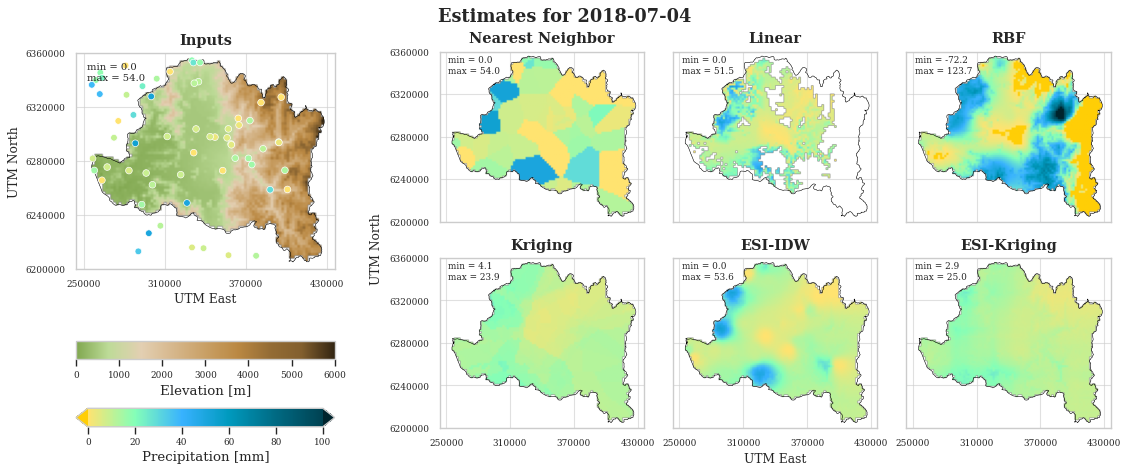

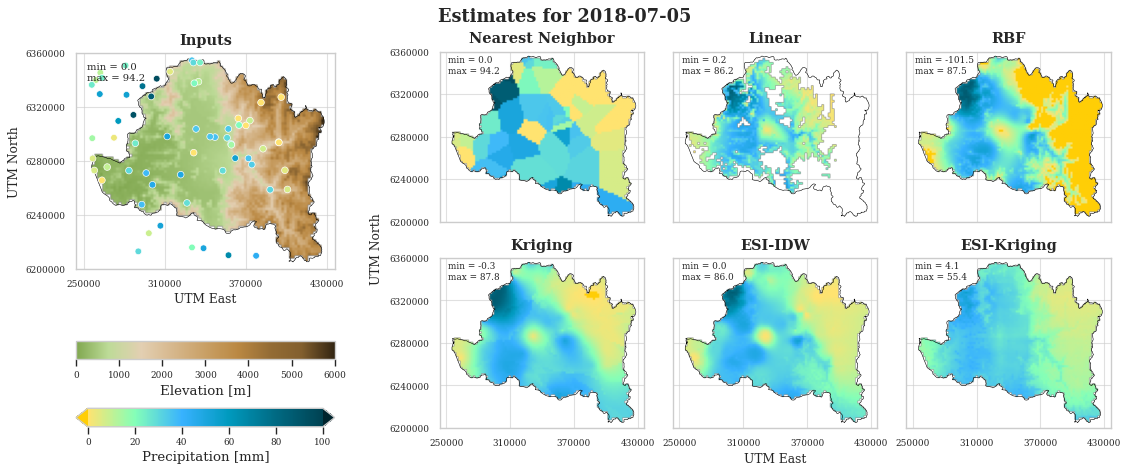

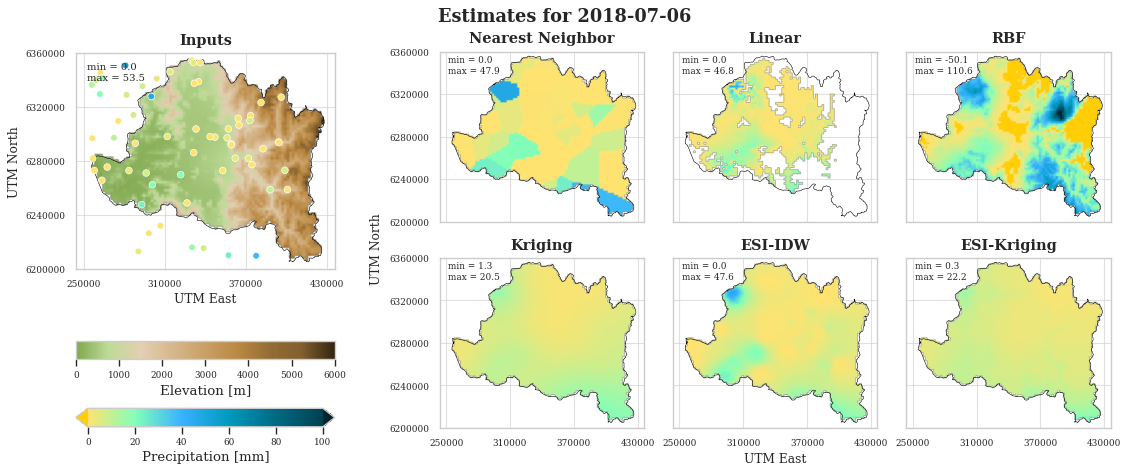

In [12]:
# PLOTTING THE RESULTS
for i, date in enumerate(case_study.dates):
    fig, subfigs, ax0, axs = case_study.plot_model_comparison(results, date, 
                                                              interpolators=['nearest', 'linear', 'rbf', 'kriging', 'esi idw', 'esi kriging'],
                                                              names=['Nearest Neighbor', 'Linear', 'RBF', 'Kriging', 'ESI-IDW', 'ESI-Kriging'],
                                                              dpi=80)
    plt.show()


As previously observed, ESI estimates show reasonable values and spatial structure, effectively handling extreme values and abrupt transitions for all three dates.
It can be seen that the the other models encounter difficulties in this complex scenario:
- Nearest Neighbor interpolations exhibit abrupt boundaries
- RBF interpolators significantly exceed the observed data ranges
- Kriging estimates show a considerable degree of smoothing, completely ignoring the maximum values in two out three dates

### Performance evaluation

Finally, we evaluate the performance of each method using leave-one-out cross-validaiton.

In [30]:
# Auxiliar functions for the evaluation
def esi_prediction(points, values, xi, **kwargs):
    result = esi_nongriddata(points, values, xi, n_partitions = 300, seed=42, **kwargs)
    return result.estimation()

def rbf_prediction(points, values, xi, **kwargs):
    return RBFInterpolator(points, values)(xi)

def scipy_prediction(points, values, xi, **kwargs):
    return griddata(points, values, xi, **kwargs)

def kriging_prediction(points, values, xi, **kwargs):
    np.random.seed(42)
    kriging = Krige(**kwargs)
    kriging.fit(points, values)
    return kriging.predict(xi)

def loo_validation(points, values, interpolation_function, **interpolation_kwargs):
    """
    Leave-one-out cross-validation for spatial interpolation methods.
    """
    n_samples = len(points)
    predictions = np.zeros_like(values)
    
    for i in range(n_samples):
        # Leave out sample i
        train_mask = np.ones(n_samples, dtype=bool)
        train_mask[i] = False
        
        points_train = points[train_mask]
        values_train = values[train_mask]
        
        # Query location (the left-out sample)
        xi = points[i:i+1]
        
        # Estimate at left-out location
        try:
            with SuppressOutput():
                pred = interpolation_function(points_train, values_train, xi, **interpolation_kwargs)
            predictions[i] = pred[0]

        except Exception as e:
            print(f"Warning: Failed at sample {i}: {e}")
            predictions[i] = np.nan
    
    # Compute metrics
    errors = np.abs(predictions - values)
    squared_errors = (predictions - values) ** 2
    
    # Filter out NaN values
    valid_mask = ~np.isnan(predictions)
    
    mae = np.mean(errors[valid_mask])
    rmse = np.sqrt(np.mean(squared_errors[valid_mask]))

    return mae, rmse


In [31]:
# Executing leave-one-out cross-validation
loo_results = []

names = ['Nearest Neighbor', 'Linear', 'RBF', 'Kriging', 'ESI-IDW', 'ESI-Kriging']
functions = [scipy_prediction,
             scipy_prediction,
             rbf_prediction,
             kriging_prediction,
             esi_prediction,
             esi_prediction]

for date in case_study.dates:
    print(f"Running LOO cross-validation for {date}")

    # for the methods with configurable parameters, we reuse the optimal values previously found
    args_list = [{'method': 'nearest'},
                {'method': 'linear'},
                {},
                {'method': parameters_ok.loc[date, 'method'],
                 'n_closest_points': parameters_ok.loc[date, 'n_closest_points'],
                 'variogram_model': parameters_ok.loc[date, 'variogram_model'],
                 'nlags': parameters_ok.loc[date, 'nlags']},
                {'local_interpolator': 'idw',
                 'alpha': parameters_idw.loc[date, 'alpha'],
                 'exponent': parameters_idw.loc[date, 'exponent']},
                {'local_interpolator': 'kriging',
                 'alpha': parameters_kriging.loc[date, 'alpha'],
                 'model': parameters_kriging.loc[date, 'model'],
                 'nugget': parameters_kriging.loc[date, 'nugget'],
                 'range': parameters_kriging.loc[date, 'range'],
                 'sill': 1}
    ]
    for function, args, name in zip(functions, args_list, names):
        mae, rmse = loo_validation(points[date], values[date], function, **args)

        loo_results.append({'date': date, 'method': name, 'MAE': mae, 'RMSE': rmse})

loo_results_df = pd.DataFrame(loo_results)


Running LOO cross-validation for 2018-07-04
Running LOO cross-validation for 2018-07-05
Running LOO cross-validation for 2018-07-06


In [32]:
loo_results_df.set_index(['date', 'method'])

MAE  RMSE
date       method                      
2018-07-04 Nearest Neighbor 11.27 16.11
           Linear            9.84 14.59
           RBF              13.68 20.47
           Kriging           9.83 13.82
           ESI-IDW           9.33 13.48
           ESI-Kriging       9.63 13.03
2018-07-05 Nearest Neighbor 17.35 25.11
           Linear           14.16 20.89
           RBF              17.04 22.90
           Kriging          13.21 18.39
           ESI-IDW          12.80 17.24
           ESI-Kriging      14.27 18.24
2018-07-06 Nearest Neighbor  7.53 12.64
           Linear            7.11 11.29
           RBF              10.24 16.74
           Kriging           7.05 10.80
           ESI-IDW           6.84 10.75
           ESI-Kriging       7.18 10.79

The results show that, for this case study, ESI with IDW as local interpolator obtains the lowest MAE and RMSE values across almost all dates. The only exception is the RMSE for July 4th, where ESI-Kriging obtains the lowest value.